In [1]:
import tensorflow as tf
tf.test.is_gpu_available()
#tf.test.is_built_with_cuda()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [5]:
import argparse
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras 
from imutils import paths
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TensorBoard
)
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras import backend as K


from model_mobile import get_model
#from utils import Metrics  # Abhi 

os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [6]:
def focal_loss(y_true, y_pred):
    gamma = 5
    alpha = 0.25
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))

In [7]:

DATA_DIR = 'C:/Users/212733771/Documents/Covid-Ultrasound/selected_frames/'
MODEL_DIR = 'C:/Users/212733771/Documents/Covid-Ultrasound/models'
FOLD = 0
LR = 1e-5
EPOCHS = 50
BATCH_SIZE = 16
TRAINABLE_BASE_LAYERS = 1
IMG_WIDTH, IMG_HEIGHT = (224,224)
NUM_CH = 3

In [8]:
model_name = 'pocus_fold_{0}'
plot_path = 'pocus_fold_{0}'

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [9]:
train_val_test={}
label_dict = {'cov':'covid','reg':'regular','pneu':'pneumonia'}
for test_train_dir in os.listdir(DATA_DIR):
    #print(test_train_dir)
    save_image_dir_foldwide = os.path.join(DATA_DIR,test_train_dir)
    label_flod={}
    # label_flod.append(test_train_dir)
    for key,label_folder in label_dict.items():
        print(label_folder)
        fold_path = os.path.join(save_image_dir_foldwide,label_folder)
        print(len(os.listdir(fold_path)))
        # label_flod.append(os.listdir(fold_path))
        label_flod[key]=[os.path.join(fold_path, f) for f in os.listdir(fold_path)] #os.listdir(fold_path)
    train_val_test[test_train_dir] = label_flod

covid
165
regular
83
pneumonia
267
covid
187
regular
126
pneumonia
173
covid
404
regular
122
pneumonia
392
covid
458
regular
83
pneumonia
81
covid
177
regular
98
pneumonia
352


In [10]:
train_folders=['train_test_1','train_test_2','train_test_3']
val_folders=['train_test_4']
test_folders=['train_test_5']
train_path=[]
train_data=[]
train_labels=[]
val_path=[]
val_data=[]
val_labels=[]
test_path=[]
test_data=[]
test_labels=[]
for path_key,folder in train_val_test.items():
    print(path_key)
    for type_key,paths in folder.items():
        print(type_key)
        print(len(paths))
        if (path_key in train_folders):
           train_path+= paths
           for imagePath in paths:
                image_org = np.load(imagePath,allow_pickle=False)
                assert image_org.shape[0] == 3
                image=np.zeros(shape=(IMG_WIDTH, IMG_HEIGHT,image_org.shape[0])).astype(image_org.dtype)
                for i in range(len(image_org)):
                    # image[i] = cv2.cvtColor(image[i], cv2.COLOR_BGR2RGB)  
                    image[:,:,i] = cv2.resize(cv2.cvtColor(image_org[i], cv2.COLOR_BGR2GRAY), (IMG_WIDTH, IMG_HEIGHT)) 
                train_labels.append(type_key)
                train_data.append(image)                      
        if (path_key in val_folders):
           val_path+= paths
           for imagePath in paths:
                image_org = np.load(imagePath,allow_pickle=False)
                assert image_org.shape[0] == 3
                image=np.zeros(shape=(IMG_WIDTH, IMG_HEIGHT,image_org.shape[0])).astype(image_org.dtype)
                for i in range(len(image_org)):
                    # image[i] = cv2.cvtColor(image[i], cv2.COLOR_BGR2RGB)  
                    image[:,:,i] = cv2.resize(cv2.cvtColor(image_org[i], cv2.COLOR_BGR2GRAY), (IMG_WIDTH, IMG_HEIGHT)) 
                val_labels.append(type_key)
                val_data.append(image)             
        if (path_key in test_folders):
           test_path+= paths   
           for imagePath in paths:
                image_org = np.load(imagePath,allow_pickle=False)
                assert image_org.shape[0] == 3
                image=np.zeros(shape=(IMG_WIDTH, IMG_HEIGHT,image_org.shape[0])).astype(image_org.dtype)
                for i in range(len(image_org)):
                    # image[i] = cv2.cvtColor(image[i], cv2.COLOR_BGR2RGB)  
                    image[:,:,i] = cv2.resize(cv2.cvtColor(image_org[i], cv2.COLOR_BGR2GRAY), (IMG_WIDTH, IMG_HEIGHT)) 
                test_labels.append(type_key)
                test_data.append(image)                     

print(
    '\nNumber of training samples: '+str(len(train_labels))+' \n'
    'Number of testing samples: '+str(len(test_labels))+''
)

train_data = np.array(train_data)
test_data = np.array(test_data)
val_data = np.array(val_data)

train_test_1
cov
165
reg
83
pneu
267
train_test_2
cov
187
reg
126
pneu
173
train_test_3
cov
404
reg
122
pneu
392
train_test_4
cov
458
reg
83
pneu
81
train_test_5
cov
177
reg
98
pneu
352

Number of training samples: 1919 
Number of testing samples: 627


In [11]:
assert len(set(train_labels)) == len(set(test_labels)), (
    'Something went wrong. Some classes are only in train or test data.'
)  # yapf: disable

train_data = (train_data-train_data.mean()) / train_data.std()
test_data = (test_data-test_data.mean()) / test_data.std()
val_data = (val_data-val_data.mean()) / val_data.std()
train_labels_text = np.array(train_labels)
test_labels_text = np.array(test_labels)
val_labels_text = np.array(val_labels)

num_classes = len(set(train_labels))

# perform one-hot encoding on the labels
lb = LabelBinarizer()
lb.fit(train_labels_text)
train_labels = lb.transform(train_labels_text)
lb.fit(test_labels_text)
test_labels = lb.transform(test_labels_text)
lb.fit(val_labels_text)
val_labels = lb.transform(val_labels_text)

In [12]:
print(train_data.shape)
print(test_data.shape)
print(val_data.shape)
print(train_labels.shape)
print(test_labels.shape)
print(val_labels.shape)

(1919, 224, 224, 3)
(627, 224, 224, 3)
(622, 224, 224, 3)
(1919, 3)
(627, 3)
(622, 3)


In [13]:
if num_classes == 2:
    train_labels = to_categorical(train_labels, num_classes=num_classes)
    test_labels = to_categorical(test_labels, num_classes=num_classes)

trainX = train_data
trainY = train_labels
testX = test_data
testY = test_labels
valX = val_data
valY = val_labels
print('Class mappings are:', lb.classes_)

# initialize the training data augmentation object
trainAug = ImageDataGenerator(
    rotation_range=10,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Load the VGG16 network
model = get_model(
    input_size=(IMG_WIDTH, IMG_HEIGHT, 3), num_classes=num_classes
)

Class mappings are: ['cov' 'pneu' 'reg']


In [14]:
num_layers = len(model.layers)
num_layers

93

In [18]:
# Number of layers in model head (fresh weights), this is fixed in get_model.
#num_head_layers =30
# Freeze all VGG layers apart from the last layers (TRAINABLE_BASE_LAYERS)
#num_layers = len(model.layers)
#for ind, layer in enumerate(model.layers):
#    if ind < num_layers - num_head_layers - TRAINABLE_BASE_LAYERS:
#        layer.trainable = False

checkpoint_path = os.path.join(MODEL_DIR, 'ep{epoch:03d}-loss{loss:.3f}.h5')

checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, period=3, save_best_only=True, save_weights_only=False, mode='max')
csv_logger = CSVLogger(os.path.join(MODEL_DIR, '/fold_' + str(FOLD) + '_model_loss.csv'), separator=',', append=False)
addptiveLr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min', min_delta=0.001, cooldown=0, min_lr=0)
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=25)
tb = TensorBoard(os.path.join(MODEL_DIR, 'fold_' + str(FOLD) + '_tb') )
callback_list = [checkpoint,csv_logger,tb,es,addptiveLr]
# model.compile(optimizer=Adam(lr=1e-5), loss='mean_squared_error')
model.compile(optimizer=Adam(lr=1e-5), loss=focal_loss)


verbose =True

model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BATCH_SIZE),
    steps_per_epoch=len(trainX) // BATCH_SIZE,
    validation_data=(valX, valY),
    validation_steps=len(valX) // BATCH_SIZE,
    epochs=EPOCHS,
    verbose = verbose,
    callbacks=callback_list
)

C:\Users\212733771\AppData\Local\Temp\ipykernel_23352\1475550663.py:23: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/50
119/119 [==============================] - 64s 508ms/step - loss: 2.1159 - lr: 1.0000e-05
Epoch 2/50
119/119 [==============================] - 56s 473ms/step - loss: 1.6649 - lr: 1.0000e-05
Epoch 3/50
119/119 [==============================] - 56s 466ms/step - loss: 1.3238 - lr: 1.0000e-05
Epoch 4/50
119/119 [==============================] - 55s 464ms/step - loss: 0.9910 - lr: 1.0000e-05
Epoch 5/50
119/119 [==============================] - 58s 489ms/step - loss: 0.6966 - lr: 1.0000e-05
Epoch 6/50
119/119 [==============================] - 60s 501ms/step - loss: 0.7717 - lr: 1.0000e-05
Epoch 7/50
119/119 [==============================] - 59s 493ms/step - loss: 0.6632 - lr: 1.0000e-05
Epoch 8/50
119/119 [==============================] - 57s 474ms/step - loss: 0.5969 - lr: 1.0000e-05
Epoch 9/50
119/119 [==============================] - 59s 497ms/step - loss: 0.5606 - lr: 1.0000e-05
Epoch 10/50
119/119 [==============================] - 61s 514ms/step - loss: 0.4497 - lr: 

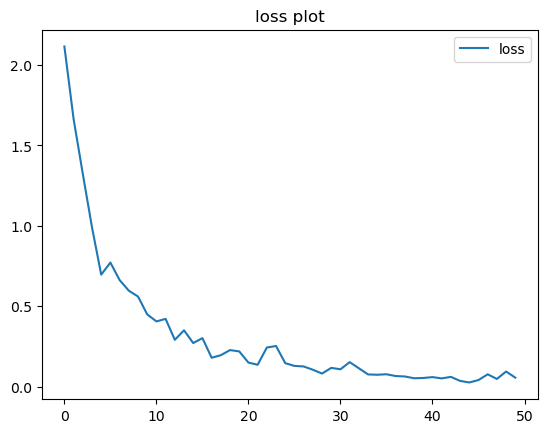

In [19]:
fig2 = plt.figure()
plt.plot(model.history.history["loss"], label="loss")
plt.title("loss plot")
# plt.plot(model.history.history["val_loss"], label="val_loss")
plt.legend()
fig2.savefig(os.path.join(MODEL_DIR, 'fold_' + str(FOLD) + '_loss_plot.png') )

In [20]:
predIdxs = model.predict(valX, batch_size=BATCH_SIZE)
predIdxs = np.argmax(predIdxs, axis=1)
print('Val data classification report sklearn:')
print(
    classification_report(
        valY.argmax(axis=1), predIdxs, target_names=lb.classes_
    )
)

39/39 [==============================] - 9s 211ms/step
Val data classification report sklearn:
              precision    recall  f1-score   support

         cov       0.87      1.00      0.93       458
        pneu       1.00      1.00      1.00        81
         reg       0.94      0.19      0.32        83

    accuracy                           0.89       622
   macro avg       0.94      0.73      0.75       622
weighted avg       0.90      0.89      0.86       622



In [21]:
predIdxs = model.predict(testX, batch_size=1)
predIdxs = np.argmax(predIdxs, axis=1)
print('Test data classification report sklearn:')
print(
    classification_report(
        testY.argmax(axis=1), predIdxs, target_names=lb.classes_
    )
)

627/627 [==============================] - 9s 13ms/step
Test data classification report sklearn:
              precision    recall  f1-score   support

         cov       0.89      1.00      0.94       177
        pneu       0.98      0.99      0.99       352
         reg       0.97      0.70      0.82        98

    accuracy                           0.95       627
   macro avg       0.95      0.90      0.92       627
weighted avg       0.95      0.95      0.95       627



In [22]:
# serialize the model to disk
print('Saving COVID-19 detector model on {model_name} data...')
model.save(os.path.join(MODEL_DIR, model_name), save_format='h5')

Saving COVID-19 detector model on {model_name} data...


In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [24]:
from keras.models import load_model
model_loaded = load_model(os.path.join(MODEL_DIR, model_name), compile=False)

In [25]:
testX_exp=testX.copy()
testX_exp[:,:,:,0]=0
testX_exp[:,:,:,2]=0

predIdxs = model.predict(testX_exp, batch_size=8)
predIdxs = np.argmax(predIdxs, axis=1)
print('Test data classification report sklearn:')
print(
    classification_report(
        testY.argmax(axis=1), predIdxs, target_names=lb.classes_
    )
)

79/79 [==============================] - 9s 100ms/step
Test data classification report sklearn:
              precision    recall  f1-score   support

         cov       0.80      1.00      0.89       177
        pneu       0.94      0.99      0.96       352
         reg       0.97      0.36      0.52        98

    accuracy                           0.89       627
   macro avg       0.90      0.78      0.79       627
weighted avg       0.90      0.89      0.87       627



In [26]:
testX_exp=testX.copy()
testX_exp[:,:,:,0]=testX_exp[:,:,:,1]
testX_exp[:,:,:,2]=testX_exp[:,:,:,1]

predIdxs = model.predict(testX_exp, batch_size=BATCH_SIZE)
predIdxs = np.argmax(predIdxs, axis=1)
print('Test data classification report sklearn:')
print(
    classification_report(
        testY.argmax(axis=1), predIdxs, target_names=lb.classes_
    )
)

40/40 [==============================] - 7s 171ms/step
Test data classification report sklearn:
              precision    recall  f1-score   support

         cov       0.95      0.91      0.93       177
        pneu       0.99      0.98      0.98       352
         reg       0.78      0.88      0.83        98

    accuracy                           0.94       627
   macro avg       0.91      0.92      0.91       627
weighted avg       0.95      0.94      0.94       627

